In [49]:
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 10 00:39:38 2015

@author: Daniel
"""

### Imaging functions for emphasizing features

# NOTE:   These functions return copies of the original array
# so as not to destroy the original
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pnd

import numpy as np
import random
os.getcwd()
import numpy as np
from scipy import ndimage

def hipass(image,gaussrad,dilrat):
    # 
    # A derivative of gaussian (suggested radii of 0.5) to get edges
    # followed by a morphological dilate to widen the effect and pick up extra pixels on edges
    # This can be used as a mask for 

    timg = np.copy(image).reshape(96,96)
    
    gradim = ndimage.gaussian_gradient_magnitude(timg,gaussrad)
    
    digradim= ndimage.morphology.grey_dilation(gradim,size=(dilrat,dilrat))
    
    return digradim.flatten()
    

def thresh(image,thr):
    
    timg = np.copy(image).reshape(96,96)
    
    timg[timg<thr]=0
    
    timg[timg>=thr]=255
    
    return timg.flatten()
    
def neg(image):
    
    timg =np.copy(image).reshape(96,96)
    
    timg = 255-timg
    
    return timg.flatten()


def binarize(image):
    
    # approximate half the pixels set to 255 , half to 0
    
    timg = np.copy(image)
    
    thr = np.median(timg)
    
    return thresh(timg,thr).flatten()

def cfar(image,orad,irad):
    
    timg = np.copy(image).reshape(96,96)
    
    im = ndimage.gaussian_filter(timg,irad)
    den = ndimage.gaussian_filter(timg,orad) - im
    
    return 25*abs((timg-im)/abs(den)).flatten()+127 

def close(image,rad):
    
    timg = np.copy(image).reshape(96,96)

    return ndimage.morphology.grey_closing(timg,rad).flatten() 

    
def show(image,orad,irad,idil,thr):
    
    # This routine uses cfar for edge detection, dilation to 
    # espand the region and then threshold for using as mask
    # somewhat optimum values for parameters are 4,1,4,196
    # best overlay effect plot 0.75*original + 0.25*this image
    timg= np.copy(image).reshape(96,96)
    
    cfarimg = cfar(timg,orad,irad).reshape(96,96)
    dilimg  = ndimage.grey_dilation(cfarimg,size=(idil,idil))
    
    if thr > 0:
        rimg = thresh(dilimg,thr)
    else:
        rimg = dilimg.flatten()
        
    return rimg

In [22]:
os.chdir("D:\\Documents\Berkeley-MIDS\DATSCI_W207_IntroToML\projects\eyeseeyou")
os.chdir("nnet")
"""load data"""
with open('dataraw/training.csv','rb') as f_in:
    train = pnd.read_csv(f_in)
with open('dataraw/test.csv','rb') as f_in:
    test = pnd.read_csv(f_in)

In [23]:
"""set aside dev data"""
test_data = test
train_labels, train_data = train.iloc[:,:30], train.iloc[:,30:]

dev_data, dev_labels = train_data[5000:], train_labels.iloc[5000:]
train_data, train_labels = train_data[:5000], train_labels[:5000]
print train_labels.shape, train_data.shape

(5000, 30) (5000, 1)


In [24]:
def xy_to_index(x_coord, y_coord, rows=96, cols=96):
    """ assumes 0 index on both x and y axes """
    x_coord, y_coord = int(x_coord), int(y_coord)
    index = x_coord + cols * y_coord
    if x_coord >= cols or y_coord >= rows:
        raise Exception('Index not within image limits', index)
    return int(index)

def index_to_xy(index, rows=96, cols=96):
    y,x = divmod(index, cols)
    return (x,y)

def convert_images_to_arrays(image_data):
    out = []
    for d in image_data:
        out.append(np.row_stack( np.array([int(i) for i in d.split()])) )
    return np.array(out)

def convert_labels_to_vectors(label_data, label_index):
    out = []
    for i in xrange(len(label_data)):
        tmp = np.zeros(9216)
        lab_x, lab_y = label_data.iloc[i, label_index[0]], label_data.iloc[i, label_index[1]]
        answer = xy_to_index(lab_x, lab_y, 96, 96)
        tmp[answer] = 1
        out.append(np.row_stack(tmp))
    return np.array(out)

25.4459998608


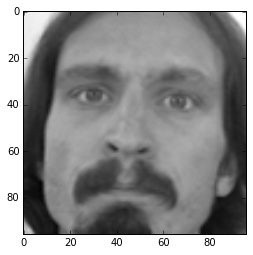

In [26]:
# CONVERT TRAINING DATA
import time

# start = time.time()
# nose_train_labels = convert_labels_to_vectors(train_labels, face['nose'])
# print 'train labels done', time.time() - start
# start = time.time()
# nose_dev_labels = convert_labels_to_vectors(dev_labels, face['nose'])
# print 'dev labels done', time.time() - start
# start = time.time()
# train_images = convert_images_to_arrays(train_data['Image'])
# print 'train images done', time.time() - start
# start = time.time()
# dev_images = convert_images_to_arrays(dev_data['Image'])
# print 'dev images done', time.time() - start


import pickle
# with open('faces.pkl', 'wb') as pk:
#     pickle.dump((train_images, dev_images, nose_train_labels, nose_dev_labels), pk)

start = time.time()
with open('faces.pkl','rb') as pk:
    train_images, dev_images, nose_train_labels, nose_dev_labels = pickle.load(pk)
print time.time() - start



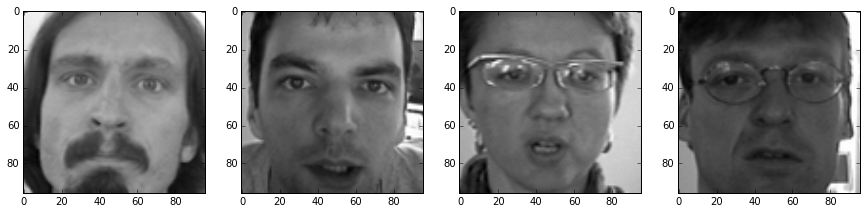

In [32]:
fig = plt.figure(figsize=(15,30))
plt.subplot(141)
plt.imshow(train_images[0].reshape(96,96), cmap='gray')
plt.subplot(142)
plt.imshow(train_images[5].reshape(96,96), cmap='gray')
plt.subplot(143)
plt.imshow(train_images[10].reshape(96,96), cmap='gray')
plt.subplot(144)
plt.imshow(train_images[15].reshape(96,96), cmap='gray')

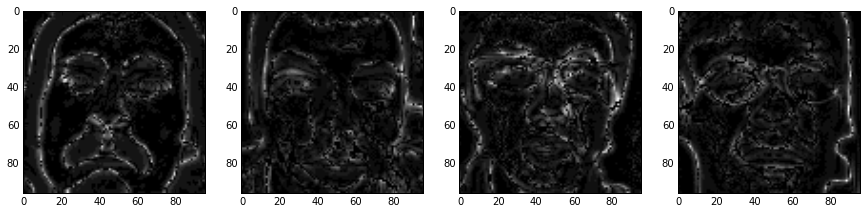

In [39]:
fig = plt.figure(figsize=(15,30))
plt.subplot(141)
plt.imshow(np.log(abs(cfar(train_images[0],7,3))).reshape(96,96), cmap='gray')
plt.subplot(142)
plt.imshow(np.log(abs(cfar(train_images[5],7,3))).reshape(96,96), cmap='gray')
plt.subplot(143)
plt.imshow(np.log(abs(cfar(train_images[10],7,3))).reshape(96,96), cmap='gray')
plt.subplot(144)
plt.imshow(np.log(abs(cfar(train_images[15],7,3))).reshape(96,96), cmap='gray')


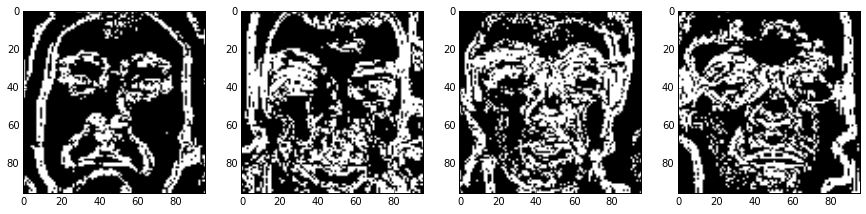

In [45]:
fig = plt.figure(figsize=(15,30))
plt.subplot(141)
plt.imshow(thresh(cfar(train_images[0],7,3),177).reshape(96,96), cmap='gray')
plt.subplot(142)
plt.imshow(thresh(cfar(train_images[5],7,3),177).reshape(96,96), cmap='gray')
plt.subplot(143)
plt.imshow(thresh(cfar(train_images[10],7,3),177).reshape(96,96), cmap='gray')
plt.subplot(144)
plt.imshow(thresh(cfar(train_images[15],7,3),177).reshape(96,96), cmap='gray')

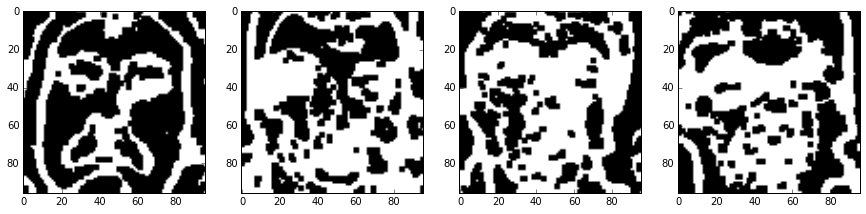

In [52]:
fig = plt.figure(figsize=(15,30))
plt.subplot(141)
plt.imshow(close(thresh(cfar(train_images[0],7,3),160),3).reshape(96,96), cmap='gray')
plt.subplot(142)
plt.imshow(close(thresh(cfar(train_images[5],7,3),160),3).reshape(96,96), cmap='gray')
plt.subplot(143)
plt.imshow(close(thresh(cfar(train_images[10],7,3),160),3).reshape(96,96), cmap='gray')
plt.subplot(144)
plt.imshow(close(thresh(cfar(train_images[15],7,3),160),3).reshape(96,96), cmap='gray')